# Generate motion

In [1]:
// for local development
%install-location /notebooks/language2motion.gt/swift-install
%install-swiftpm-flags -c release
%install '.package(path: "/notebooks/language2motion.gt")' Datasets TranslationModels TextModels ModelSupport SummaryWriter LangMotionModels

[1/2] Compiling LangMotionModels LangMotionModel.swift
[2/3] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[3/3] Linking libjupyterInstalledPackages.so
Initializing Swift...
Installation complete!


In [2]:
import TensorFlow
import TextModels
import TranslationModels
import Foundation
import ModelSupport
import Datasets
import SummaryWriter
import LangMotionModels

In [3]:
import PythonKit

%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## What's the GPU?

In [4]:
import Foundation

func shell(_ command: String) -> String {
    let task = Process()
    let pipe = Pipe()

    task.standardOutput = pipe
    task.arguments = ["-c", command]
    task.launchPath = "/bin/bash"
    task.launch()

    let data = pipe.fileHandleForReading.readDataToEndOfFile()
    return String(data: data, encoding: .utf8)!
}

func sh(_ command: String) {
    print(shell(command))
}

## Download data

In [5]:
let datasetSize: DatasetSize = .mini
let dataset_name = "motion_dataset_v3.10Hz.\(datasetSize.rawValue)"

## Set training params

In [6]:
let runName = "run_1"
let batchSize = 2
// let batchSize = 150
let maxTextSequenceLength =  20
let maxMotionLength =  10
let nEpochs = 5
let learningRate: Float = 5e-4

print("runName: \(runName)")
print("batchSize: \(batchSize)")
print("maxTextSequenceLength: \(maxTextSequenceLength)")
print("maxMotionLength: \(maxMotionLength)")
print("nEpochs: \(nEpochs)")
print("learningRate: \(learningRate)")

// let dataURL = URL(fileURLWithPath: "/content/data/")
let dataURL = URL(fileURLWithPath: "/notebooks/language2motion.gt/data/")
let motionDatasetURL = dataURL.appendingPathComponent("\(dataset_name)plist")
let langDatasetURL = dataURL.appendingPathComponent("labels_ds_v2.csv")

runName: run_1
batchSize: 2
maxTextSequenceLength: 20
maxMotionLength: 10
nEpochs: 5
learningRate: 0.0005


## Select eager or X10 backend

In [7]:
// let device = Device.defaultXLA
let device = Device.defaultTFEager
print(device)

Device(kind: .CPU, ordinal: 0, backend: .TF_EAGER)


## Instantiate model

In [8]:
/// instantiate text processor
let vocabularyURL = dataURL.appendingPathComponent("vocab.txt")
let vocabulary: Vocabulary = try! Vocabulary(fromFile: vocabularyURL)
let tokenizer: Tokenizer = BERTTokenizer(vocabulary: vocabulary, caseSensitive: false, unknownToken: "[UNK]", maxTokenLength: nil)
let textProcessor = TextProcessor2(vocabulary: vocabulary, tokenizer: tokenizer, maxTextSequenceLength: maxTextSequenceLength, maxMotionLength: maxMotionLength)

/// instantiate model
let vocabSize = vocabulary.count
let nbJoints = 47 // TODO: get value from dataset
let layerCount: Int = 6
let modelSize: Int = 256
let feedForwardSize: Int = 1024
let headCount: Int = 8
let dropoutProbability: Double = 0.1

var transformer = LangMotionTransformer(
    vocabSize: vocabSize, 
    nbJoints: nbJoints,
    layerCount: layerCount, 
    modelSize: modelSize, 
    feedForwardSize: feedForwardSize, 
    headCount: headCount, 
    dropoutProbability: dropoutProbability
)

let nbMixtures = 20
// TODO: integrate MotionGaussianMixtureModel with Generator
var mixtureModel = MotionGaussianMixtureModel(inputSize: nbJoints, nbJoints: nbJoints, nbMixtures: nbMixtures)
// mixtureModel.move(to: device)

var model = LangMotionModel(transformer: transformer, mixtureModel: mixtureModel)
model.move(to: device)

## Load dataset

In [9]:
print("\nLoading dataset...")

var dataset = try Lang2Motion(
    motionDatasetURL: motionDatasetURL,
    langDatasetURL: langDatasetURL,
    batchSize: batchSize
) { (example: Lang2Motion.Example) -> LangMotionBatch in    
    let singleBatch = textProcessor.preprocess(example: example)
    return singleBatch
}

print("Dataset acquired.")


Loading dataset...
MotionDataset2(motionSamples: 1030)
keeping 834 annotatated motions
keeping 834 longer motions, with minimum 10 frames
Scaling motions...
Motions scaled.
Dataset acquired.


## Generate motion

In [26]:
public func greedyDecodeMotion(sentence: String, prefix: String = "prefix", showMotion: Bool = false) {
    // TODO: incorporate done/stop signal
    // TODO: save mmm file
    Context.local.learningPhase = .inference
    print("\ngreedyDecodeMotion(sentence: \"\(sentence)\")")

    let source = textProcessor.preprocess(sentence: sentence)
    source.printSource()

    print("\nEncode:")
    print("======")
    let memory = model.transformer.encode(input: source)
    print("  memory.count: \(memory.shape)")

    print("\nGenerate:")
    print("=========")
    // tensor for neutral motion frame
    var ys: Tensor<Float> = Tensor<Float>(repeating:0.0, shape: [1, 1, nbJoints])
    for _ in 0..<maxMotionLength {
        // print("loop \(i)")
        // print("  ys: \(ys.shape)")
        // prepare input
        let targetMask = Tensor<Float>(subsequentMask(size: ys.shape[1]))
        let target = LangMotionBatch.Target(motion: ys, mask: targetMask)

        // decode motion
        let out = model.transformer.decode(sourceMask: source.mask, target: target, memory: memory)
        // print("out.shape: \(out.shape)")
        // print("out[0...,-1].shape: \(out[0...,-1].shape)")

        let singlePreds = model.mixtureModel(model.transformer.generate(input: out[0...,-1].expandingShape(at: 0)))
        // singlePreds.printPreds()
        
        // perform sampling
        let (sampledMotion, log_probs, done) = MotionDecoder.performNormalMixtureSampling(
            preds: singlePreds, nb_joints: nbJoints, nb_mixtures: nbMixtures, maxMotionLength: maxMotionLength)
        
        // print("sampledMotion.shape: \(sampledMotion.shape)")
        
        // concatenate motion
        ys = Tensor(concatenating: [ys, sampledMotion.expandingShape(at: 0)], alongAxis: 1)
    }

    // descale motion    
    let descaled_motion = dataset.scaler.inverse_transform(ys.squeezingShape(at:0))
    print("  descaled_motion.shape: \(descaled_motion.shape)")

    let imageURL = !showMotion ? dataURL.appendingPathComponent("motion_images/\(prefix).png") : nil
    motionToImg(url: imageURL, motion: descaled_motion, motionFlag: nil, padTo: maxMotionLength, descr: "\(prefix), \(sentence)")
    if !showMotion {
        print("Saved image: \(imageURL!.path)")
    }
}


greedyDecodeMotion(sentence: "human is walking")
source
  tokenIds.shape: [1, 20]
  mask.shape: [1, 1, 20]
  tokenCount: shape [1], value [5]

Encode:
  memory.count: [1, 20, 256]

Generate:
  descaled_motion.shape: [11, 47]


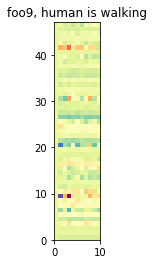

In [27]:
greedyDecodeMotion(sentence: "human is walking", prefix: "foo9", showMotion: true)